# Task
Изучаю tradesBar историю с баром из 33000 сделок, сравниваю с обычной часовой историей

# Import modules

In [37]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
# warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import make_scorer, average_precision_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [39]:
dir_final = 'D:\\BinanceData\\FinalSaveData' # Путь к файлам
coin = 'eth' # Список инструментов для загрузки
# file_type = 'trades' 
trades_in_bar = 33000 # Сколько будет сделок в одном баре
trades_bar_name = str(trades_in_bar) + '_tradesBar'


In [40]:
dir_for_trades_bar_files = f'{dir_final}\\{trades_bar_name}\\{coin}\\'

trades_bar_file_name = coin.upper() + '_' + trades_bar_name + '.parquet'
trades_bar_file_path = os.path.join(dir_for_trades_bar_files, trades_bar_file_name)

leftover_file_name = coin.upper() + '_leftover' + '.parquet'
leftover_file_path = os.path.join(dir_for_trades_bar_files, leftover_file_name)

In [41]:
trades_bar_file_path

'D:\\BinanceData\\FinalSaveData\\33000_tradesBar\\eth\\ETH_33000_tradesBar.parquet'

In [42]:
data = pd.read_parquet(trades_bar_file_path)

In [43]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24971 entries, 0 to 24970
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Begin    24971 non-null  datetime64[ns]
 1   End      24971 non-null  datetime64[ns]
 2   Open     24971 non-null  float64       
 3   High     24971 non-null  float64       
 4   Low      24971 non-null  float64       
 5   Close    24971 non-null  float64       
 6   Vol      24971 non-null  float64       
 7   Vol_USD  24971 non-null  float64       
dtypes: datetime64[ns](2), float64(6)
memory usage: 1.5 MB


In [44]:
df

,Begin,End,Open,High,Low,Close,Vol,Vol_USD
0,2021-03-01 00:00:00.315,2021-03-01 00:37:23.750,1418.67,1449.99,1409.91,1445.25,35234.00,50533741.22
1,2021-03-01 00:37:23.819,2021-03-01 01:40:29.233,1445.24,1447.39,1426.30,1432.61,33215.47,47780916.13
2,2021-03-01 01:40:29.264,2021-03-01 02:38:57.311,1432.62,1456.88,1432.17,1449.44,36499.35,52727991.36
3,2021-03-01 02:38:57.323,2021-03-01 03:46:22.250,1449.44,1449.88,1431.27,1436.71,39316.12,56624290.82
4,2021-03-01 03:46:22.250,2021-03-01 04:51:26.919,1436.71,1451.92,1421.46,1451.46,38578.35,55356136.82
...,...,...,...,...,...,...,...,...
24966,2023-04-23 15:20:23.936,2023-04-23 16:37:21.426,1858.28,1864.81,1847.94,1864.81,24260.55,45052685.30
24967,2023-04-23 16:37:21.426,2023-04-23 18:06:02.183,1864.83,1872.69,1848.89,1853.55,21686.02,40404151.88
24968,2023-04-23 18:06:02.183,2023-04-23 19:00:53.572,1853.56,1857.19,1836.37,1846.18,25095.88,46387198.82
24969,2023-04-23 19:00:53.572,2023-04-23 20:23:04.998,1846.16,1852.35,1838.03,1850.50,24739.02,45683038.65


# Base Visualization

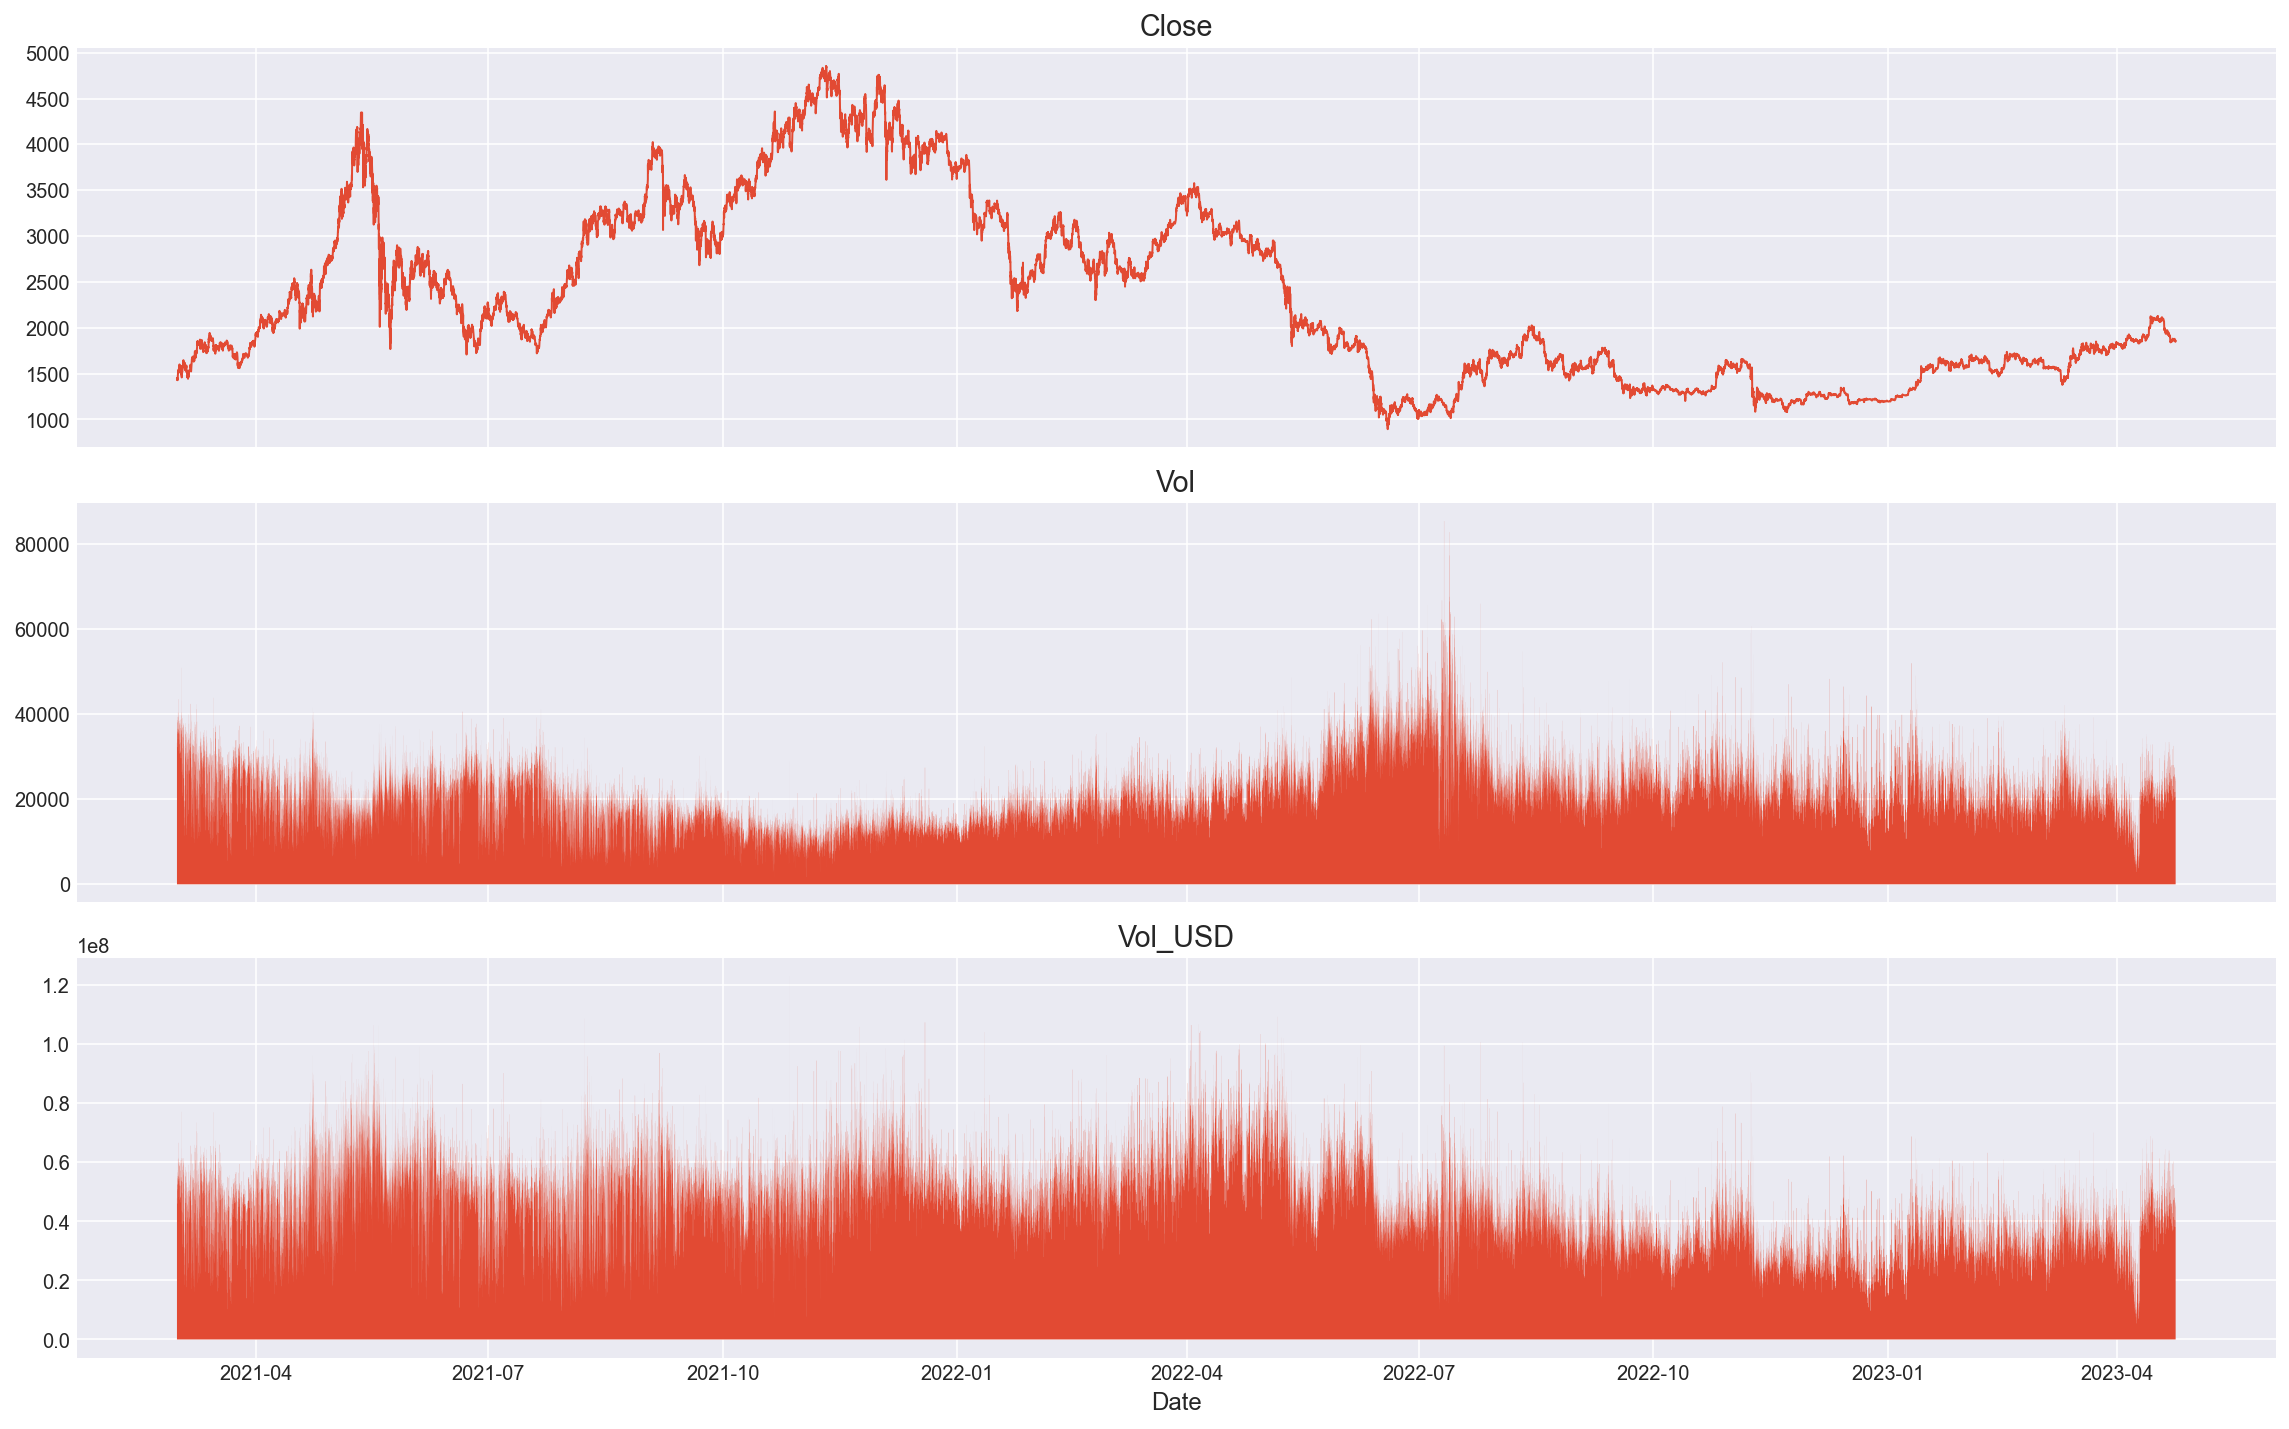

In [45]:
# If need to plot not all data
# df_to_plot = df[df['Begin'] >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot['Begin'].to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Vol'].to_numpy()
_2 = df_to_plot['Vol_USD'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Vol')

ax[2].fill_between(ind, _2, step='pre')
ax[2].set_title('Vol_USD')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Изучаю продолжительность баров

Удалю признак End, он лишний т.к. продолжительность баров уже вытащил из данных.

In [46]:
df['Duration'] = df['End'] - df['Begin']
df.drop(columns='End', inplace=True)

In [47]:
df['Duration']

0       0 days 00:37:23.435000
1       0 days 01:03:05.414000
2       0 days 00:58:28.047000
3       0 days 01:07:24.927000
4       0 days 01:05:04.669000
                 ...          
24966   0 days 01:16:57.490000
24967   0 days 01:28:40.757000
24968   0 days 00:54:51.389000
24969   0 days 01:22:11.426000
24970   0 days 02:13:32.915000
Name: Duration, Length: 24971, dtype: timedelta64[ns]

Конвертирую в минуты, но добавляю еще для исследования продолжительность баров в секундах

In [48]:
# df['Duration_sec'] = df['Duration'].dt.total_seconds()

# конвертирую в минуты, но с округлением до целого вверх, что бы не было 0 минут продолжительности у баров
df['Duration'] = np.ceil(df['Duration'].dt.total_seconds() / 60).astype(int)
df['Duration']

0         38
1         64
2         59
3         68
4         66
        ... 
24966     77
24967     89
24968     55
24969     83
24970    134
Name: Duration, Length: 24971, dtype: int32

Смотрю на распределение

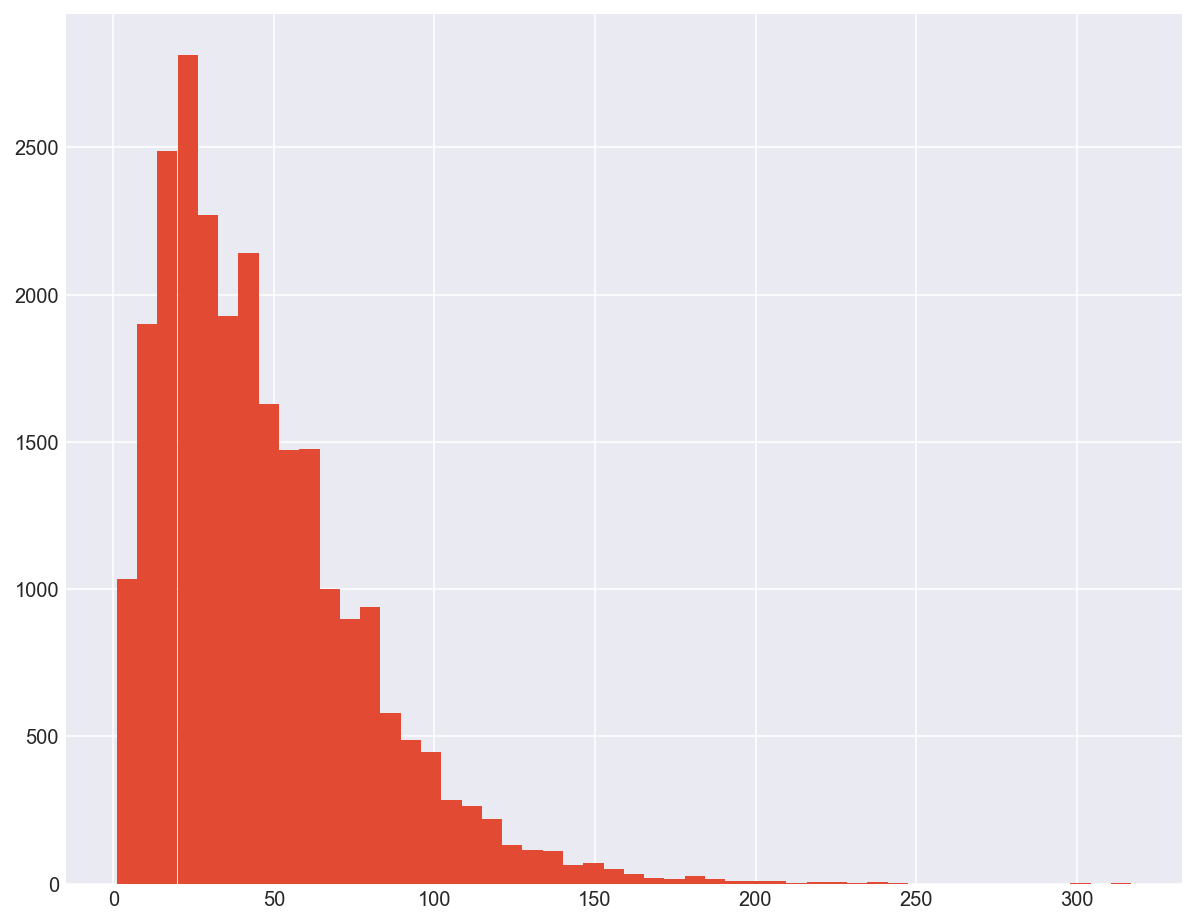

In [49]:
df['Duration'].hist(bins=50);

In [50]:
df['Duration'].describe()

count   24971.00
mean       45.70
std        31.96
min         1.00
25%        21.00
50%        39.00
75%        62.00
max       317.00
Name: Duration, dtype: float64

Есть бары по 1 минуте, я их проверил их немного но да, логика в них есть

Визуализирую цену с информацией по продолжительности баров

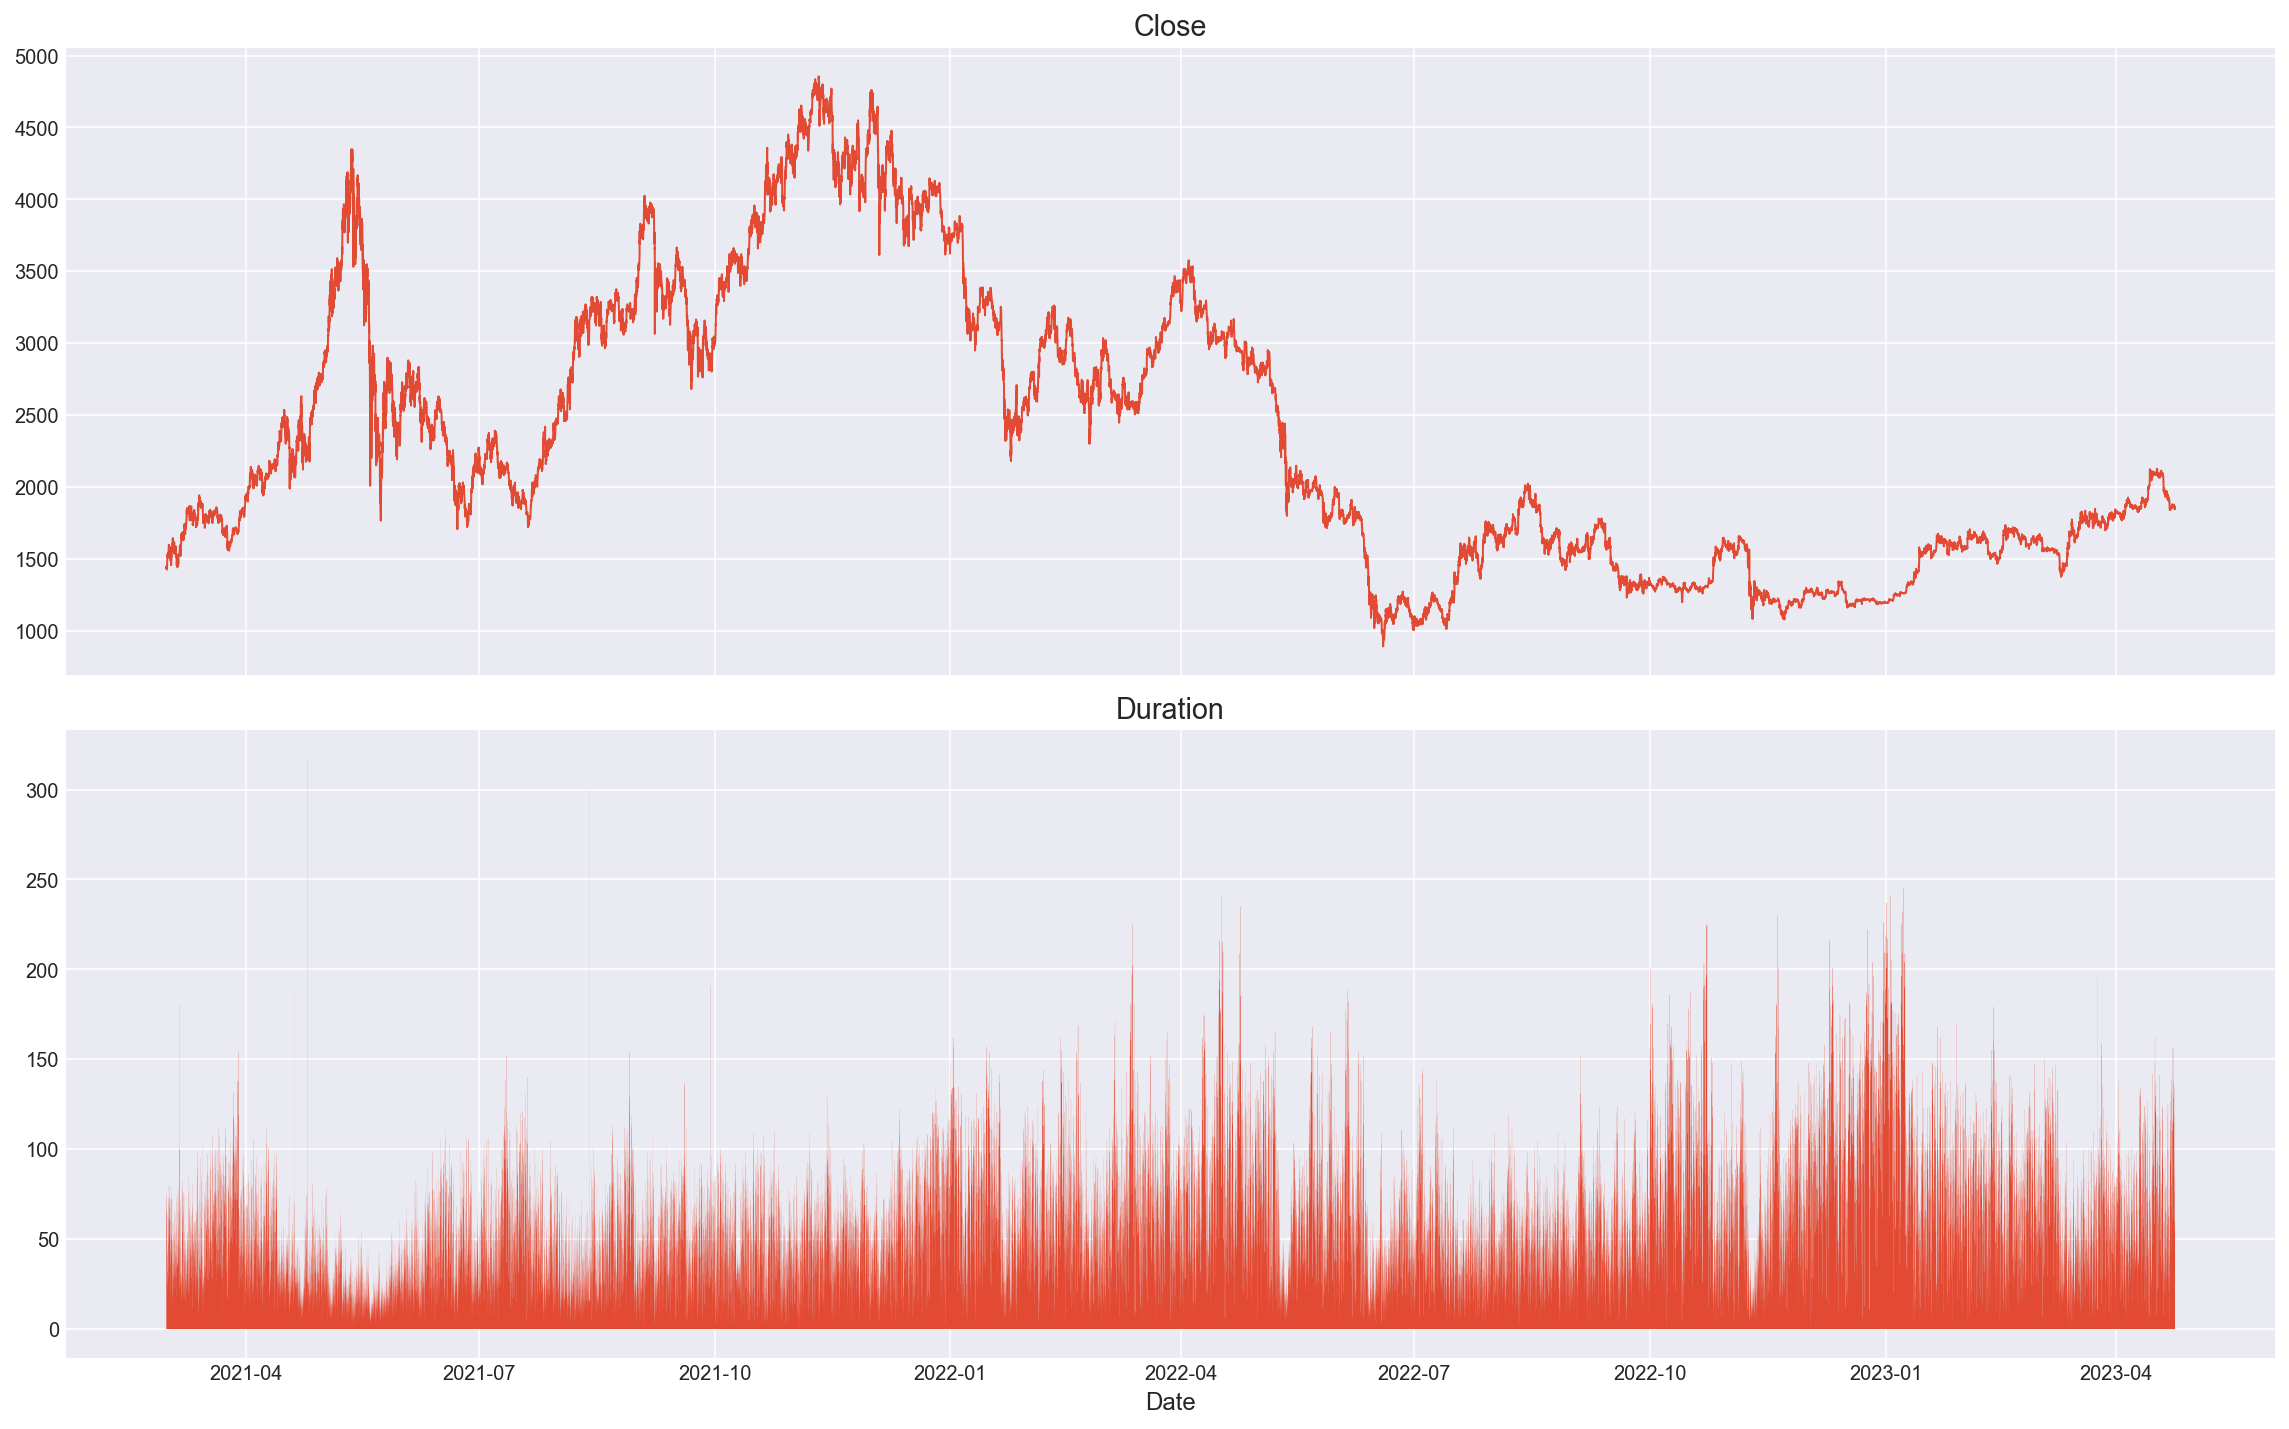

In [51]:
# If need to plot not all data
# df_to_plot = df[df['Begin'] >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot['Begin'].to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Duration'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Duration')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Временную метку переношу в индекс, так проще работать

In [52]:
df.set_index('Begin', inplace=True)

Добавляю признак дня недели

In [53]:
df['week_day'] = df.index.day_name()

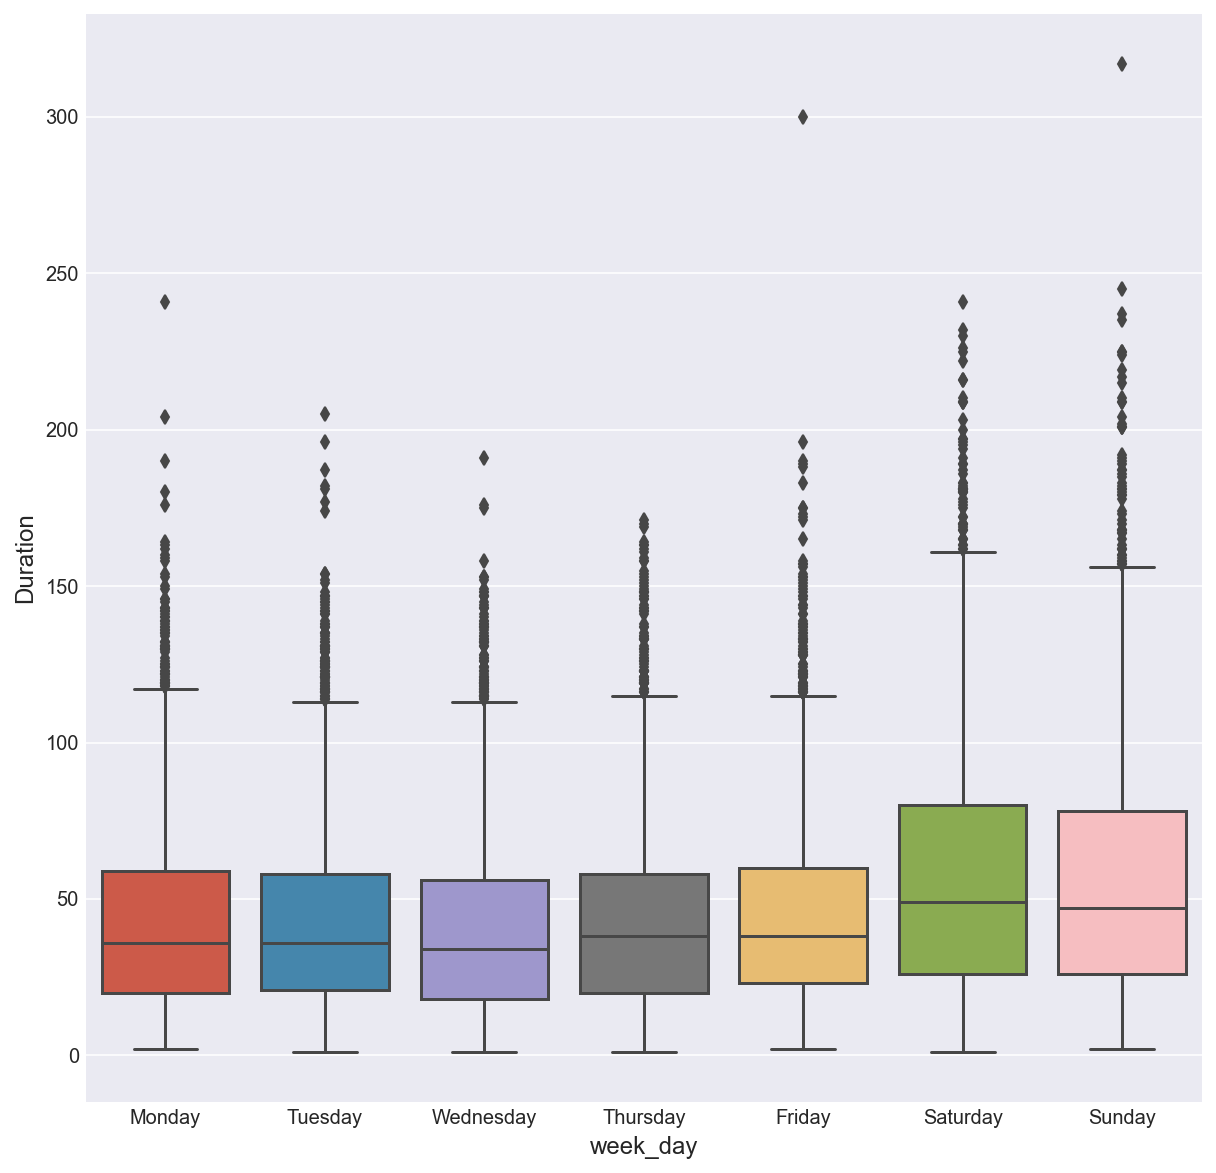

In [54]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='week_day', y='Duration');

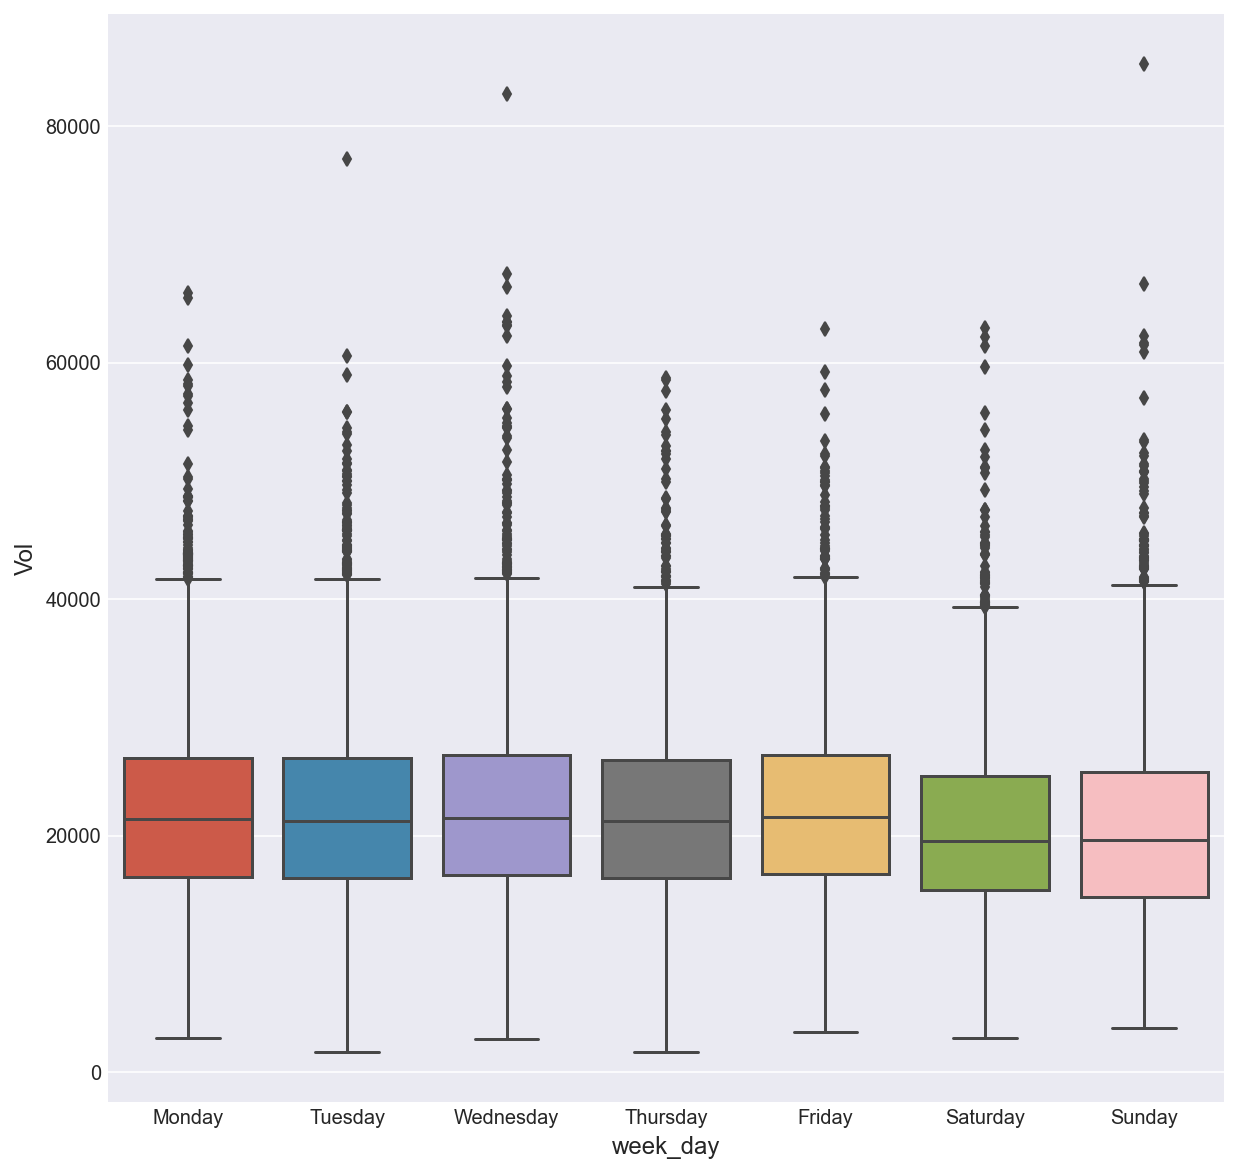

In [55]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='week_day', y='Vol');

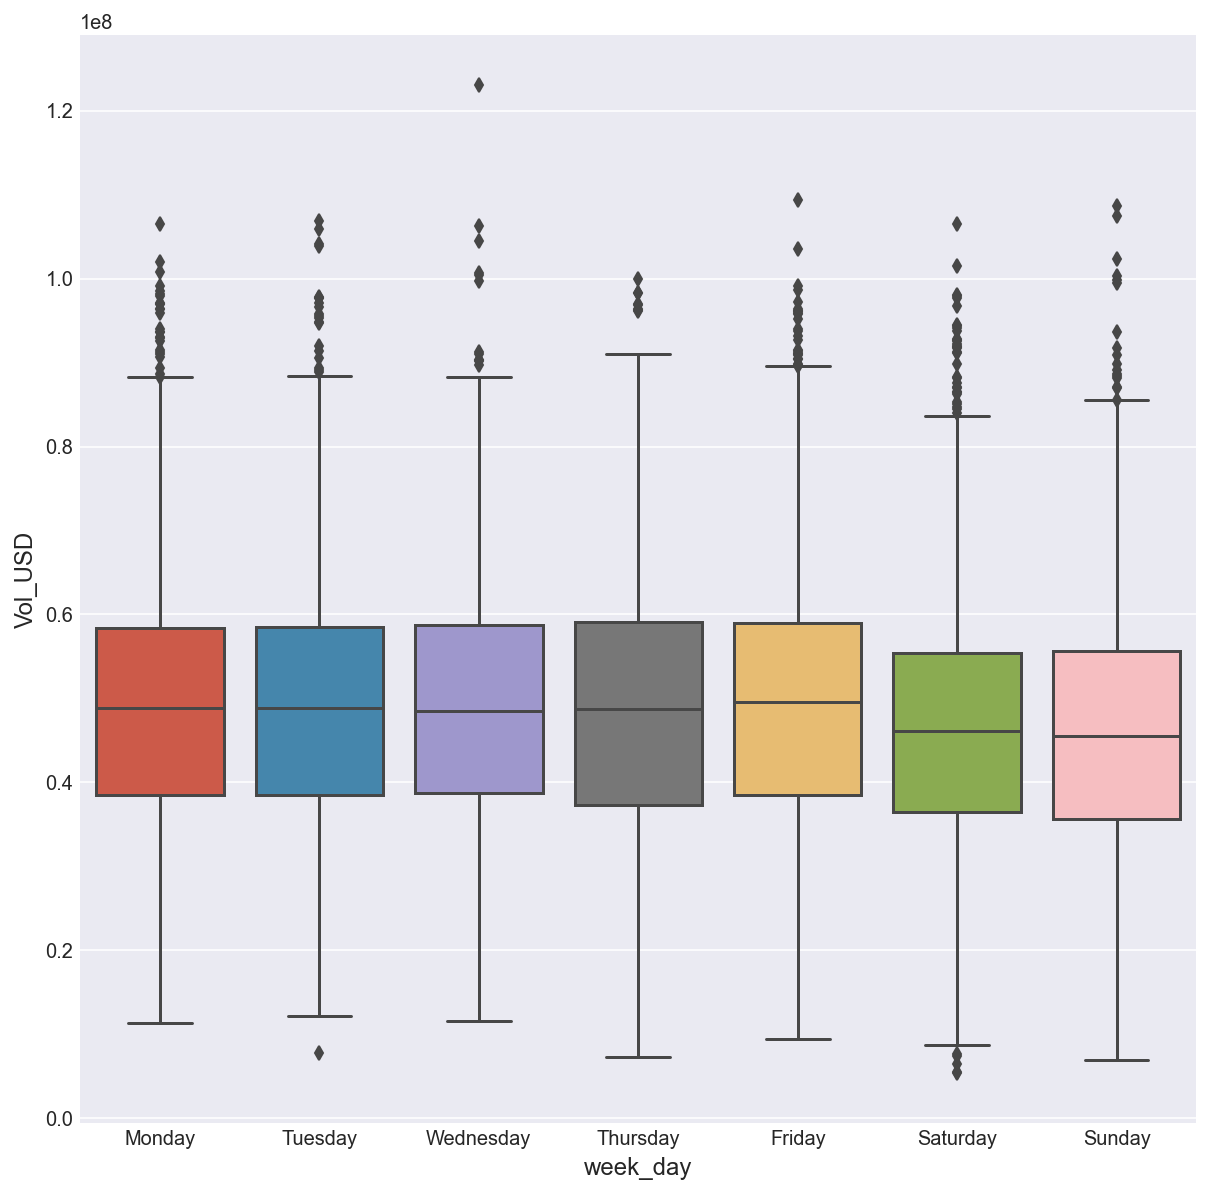

In [56]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='week_day', y='Vol_USD');

Видно что в выходные на формирование баров уходит больше времени, при этом видны более низкие торговые объемы.

In [57]:
df['Duration'].describe()

count   24971.00
mean       45.70
std        31.96
min         1.00
25%        21.00
50%        39.00
75%        62.00
max       317.00
Name: Duration, dtype: float64

Посмотрю на бары, которые формировались больше 5ч

In [58]:
mask_5h = df['Duration'] > 60*5
df[mask_5h]

,Open,High,Low,Close,Vol,Vol_USD,Duration,week_day
Begin,,,,,,,,
2021-04-25 03:47:00.605,2188.38,2239.83,2181.35,2227.07,27639.46,61194130.87,317,Sunday


Ничего необычного, просто бар в субботу утром формировался

А что за бары с продолжительностью 1 мин

In [59]:
df[df['Duration'] == 1]

,Open,High,Low,Close,Vol,Vol_USD,Duration,week_day
Begin,,,,,,,,
2021-05-13 00:02:35.548,3621.81,3647.92,3500.00,3531.50,17815.17,63480190.54,1,Thursday
2021-09-01 16:46:01.901,3715.82,3785.00,3715.00,3780.00,11481.67,43099858.96,1,Wednesday
2021-11-02 22:03:20.382,4547.68,4548.33,4523.07,4533.31,1708.30,7741136.22,1,Tuesday
2022-07-16 16:14:10.187,1370.10,1422.91,1355.57,1409.34,37918.29,52880642.19,1,Saturday
2022-10-25 17:00:19.474,1442.18,1512.01,1440.40,1485.49,30057.14,44378181.61,1,Tuesday
2022-12-13 13:30:05.715,1321.44,1349.00,1309.26,1334.56,19418.91,25875694.73,1,Tuesday


### Провека всех признаков исходного ряда на стационарность

In [60]:
# for col_name, col_data in df.items():
#     print('Column Name:', col_name)
#     hd.adf(col_data.values)
#     print()

Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую ценовые признаки

In [61]:
for col in ['Open', 'High', 'Low', 'Close']:
    df[col + '_log'] = np.log(df[col])

# df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [62]:
df

,Open,High,Low,Close,Vol,Vol_USD,Duration,week_day,Open_log,High_log,Low_log,Close_log
Begin,,,,,,,,,,,,
2021-03-01 00:00:00.315,1418.67,1449.99,1409.91,1445.25,35234.00,50533741.22,38,Monday,7.26,7.28,7.25,7.28
2021-03-01 00:37:23.819,1445.24,1447.39,1426.30,1432.61,33215.47,47780916.13,64,Monday,7.28,7.28,7.26,7.27
2021-03-01 01:40:29.264,1432.62,1456.88,1432.17,1449.44,36499.35,52727991.36,59,Monday,7.27,7.28,7.27,7.28
2021-03-01 02:38:57.323,1449.44,1449.88,1431.27,1436.71,39316.12,56624290.82,68,Monday,7.28,7.28,7.27,7.27
2021-03-01 03:46:22.250,1436.71,1451.92,1421.46,1451.46,38578.35,55356136.82,66,Monday,7.27,7.28,7.26,7.28
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 15:20:23.936,1858.28,1864.81,1847.94,1864.81,24260.55,45052685.30,77,Sunday,7.53,7.53,7.52,7.53
2023-04-23 16:37:21.426,1864.83,1872.69,1848.89,1853.55,21686.02,40404151.88,89,Sunday,7.53,7.54,7.52,7.52
2023-04-23 18:06:02.183,1853.56,1857.19,1836.37,1846.18,25095.88,46387198.82,55,Sunday,7.52,7.53,7.52,7.52


Тени от открытия бара на лог шкале

In [63]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [64]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [65]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [66]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.2


In [67]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

Анализ распределения классов целевого признака

In [68]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df
    

,%,Count
Class,,
1,10.85,2709
0,89.15,22262


На той же длине истории, но часовые бары показатели такие

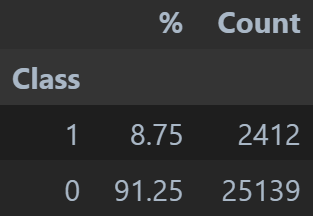

Т.е. вижу и баров больше и класс чуть более сбалансированный

# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Базовая модель - оставляю в качестве признака только Log_Return и целевой признак

In [68]:
df_new = df[['Log_Return', TARGET]].copy()

# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных, которая будет использоваться для построения прогноза T. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

In [69]:
T = 12 # len of sequence. Num of time steps to look at to make prediction on next step

Create $X$, $y$

In [70]:
X, y = hd.create_X_y_from_timeseries(df_new, TARGET, T)

In [71]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (46404, 12) y.shape: (46404,)


# Split Data
Разбиение с стратифиацией

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

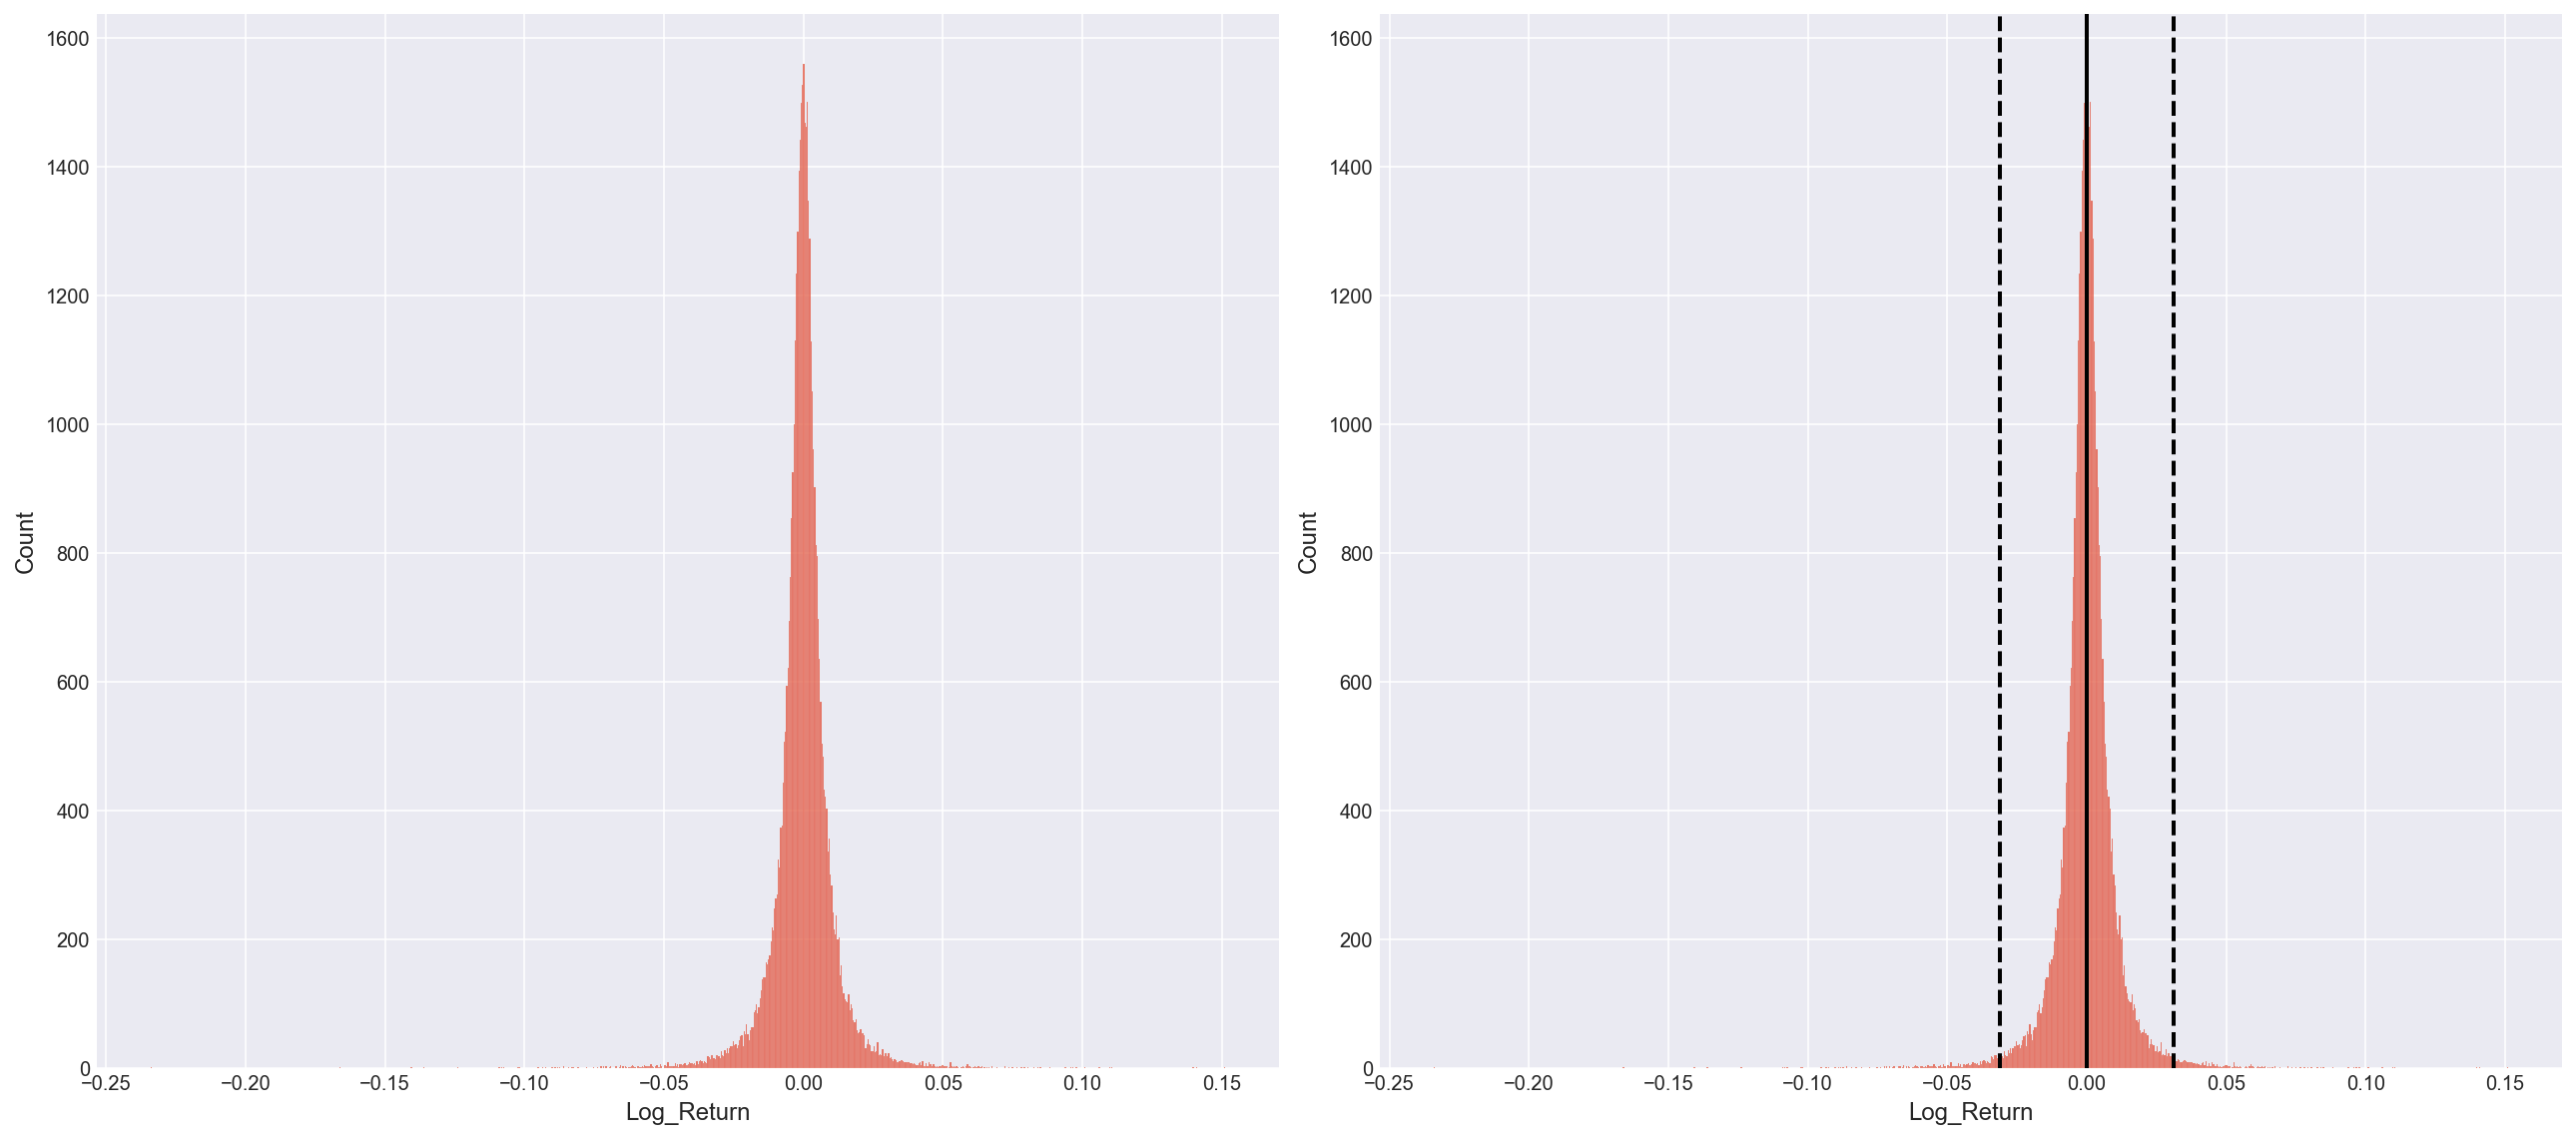

In [73]:
hd.plot_outliers_z_score(df_new, 'Log_Return', log_scale=False) # log_scale=False т.к. цены были изначально прогалорифмированы и затем еще и разница посчитана

Распределение выглядит максимально равномерно. 
Позже, на последующих итерациях можно думать о том, что бы обрезать хвосты и посмотреть как это отразится на результатах модели.

# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [74]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create Model

In [75]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [76]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.532
Precision: 0.103
Recall: 0.535
F1: 0.173

*** TEST ***
Accuracy: 0.525
Precision: 0.102
Recall: 0.539
F1: 0.172


In [77]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

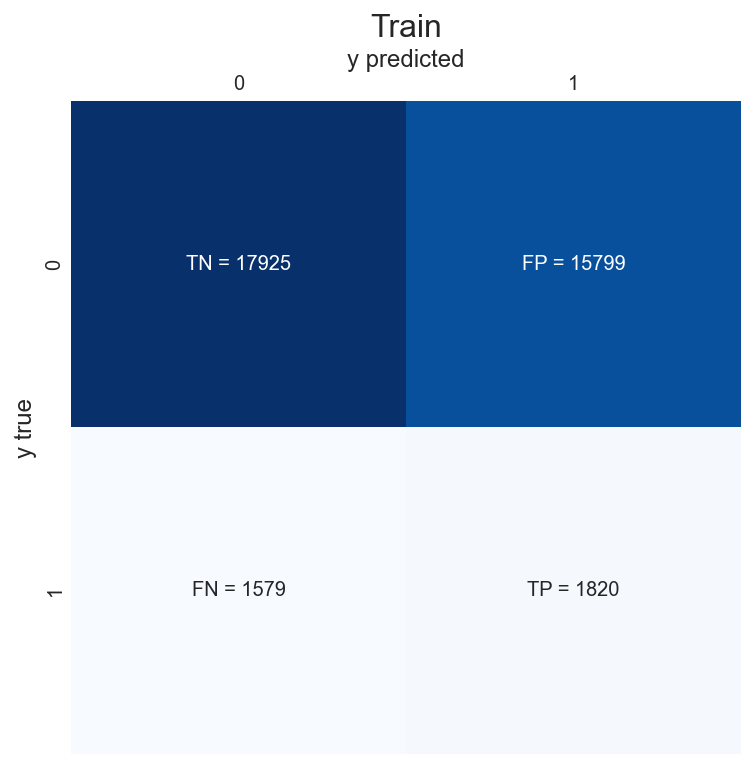

In [78]:
hd.plot_confusion_matrix(cm_train, 'Train')

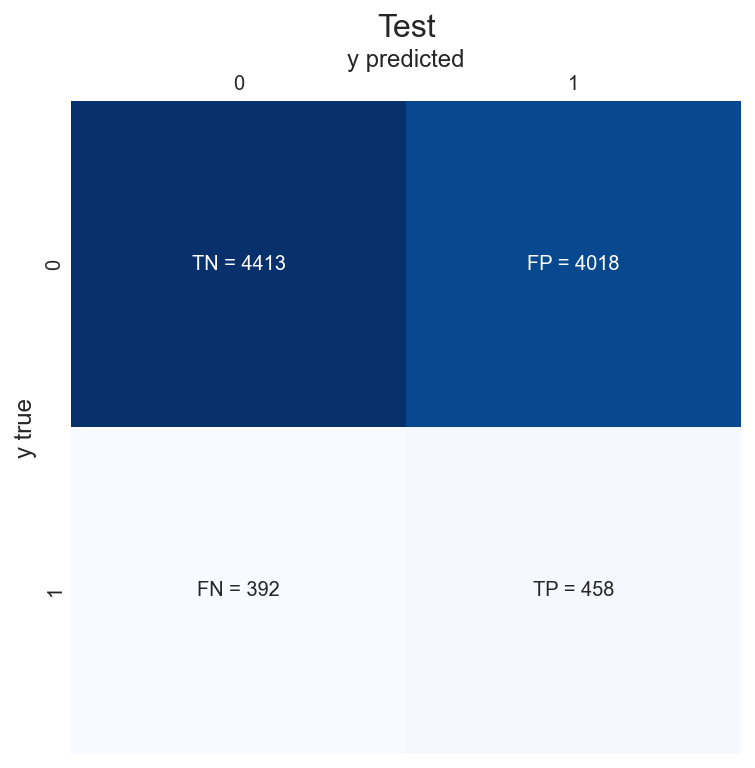

In [79]:
hd.plot_confusion_matrix(cm_test, 'Test')

In [80]:
pd.Series(y_test).value_counts()

0.0    8431
1.0     850
Name: count, dtype: int64

In [81]:
pd.Series(y_test_pred).value_counts()

0.0    4805
1.0    4476
Name: count, dtype: int64

Видно, что я очень много предсказываю класс 1, надо сильно меньше. Нужно на Precision фокусироваться.

Вот такая базовая модель.

Precision 0.101. Т.е. точность всего 10%.

*** TRAIN ***
Accuracy: 0.531
Precision: 0.104
Recall: 0.540
F1: 0.174

*** TEST ***
Accuracy: 0.528
Precision: 0.101
Recall: 0.524
F1: 0.169

# Случайный лес
подбор параметров вручную

In [82]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=5, class_weight='balanced')
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.614
Precision: 0.143
Recall: 0.645
F1: 0.234

*** TEST ***
Accuracy: 0.590
Precision: 0.124
Recall: 0.573
F1: 0.204


Моя задача это что бы Precision был больше нулевой точки матожидания.
Как свою метрику можно использовать разницу Precision-zero_mo. Чем она ближе к нулю, тем лучше. В идеале она должна быть положительной.

Так же мне нужно переводить метки в реальный подсчет результатов сделок, то что я начинал делать в ноутбуке Calulate_Result.
Ведь даже если по метрикам я промазал и был FP прогноз, это еще не значит что сделка была бы убыточной.

Нужно брать предсказанные метки, как-то соединять их с датафреймом и считать результаты сделок 

### Что я могу делать дальше:
- Добавление признаков, сейча используется лишь Log_Return. Добавляю ценовые признаки, для начала размеры теней, которые исопльзовались для генерации целевого признака
- Признак диапазона бара, размера тела в % к диапазону.
- Добавление признаков сгенерированных из даты.
- Добавление признаков сгенерированных из торгового объема.
- генерация целевого признака по сетке параметров risk_level = 0.0025, profit_factor = 4. Изучение значений Precision, zero_mo и их разницы
- обход основных моделей ML для классификации
- Из вектора предсказанных меток получение результатов торговли, надо как-то метки совмещать опять с исходным датафреймом. где бы можно было бы считать результаты торговли